In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.fft import fft2, ifft2, fftshift
import time
from time import strftime, gmtime
import numba
from numba import jit
import pandas as pd
import sys

import concurrent.futures
import multiprocessing
num_processes = multiprocessing.cpu_count()

from timeit import default_timer as timer

import sympy
import os
font = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 16,
          }

In [153]:
global first_term, second_term, third_term, V_ph, V_ph_k, rho, dt, U, dl

N = 128
L = 80

#del r_discretization, k_discretization
l = np.linspace(-L/2,L/2,N)
k = np.linspace(-1*np.pi,1*np.pi/L,N)
dl = np.abs(l[1]-l[0])
dx = dl
dy = dx
dkx = np.abs(k[1]-k[0])
dky = dkx
X, Y = np.meshgrid(l,l)

mu2_p = np.zeros((N,N))
lambda2_q = np.zeros((N,N))

p = 2 * np.pi / L
for i in range(0,N):
  for j in range(0,N//2):
    mu2_p[i,j] = pow(j * p, 2)
  for j in range(N//2,N):    
    mu2_p[i,j] = pow((j - N) * p, 2)
for j in range(0,N):     
  for i in range(0,N//2):    
    lambda2_q[i,j] = pow(i * p, 2);    
  for i in range(N//2,N):    
    lambda2_q[i,j] = pow((i - N) * p, 2)
    
#K2 = mu2_p+lambda2_q
Kx, Ky = np.meshgrid(k,k)
K2 = Kx*Kx + Ky*Ky
K = np.sqrt(K2)

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)

#Initializing the terms
first_term = np.zeros((N,N), dtype=np.complex64)
second_term = np.zeros((N,N), dtype=np.complex64)
third_term = np.zeros((N,N), dtype=np.complex64)

V_ph = np.zeros((N,N), dtype=np.complex64) 
V_ph_k = np.zeros((N,N), dtype=np.complex64)

@numba.jit(nopython=True, parallel=True)
def calculate_second_term(g):
  #Calculating the second gradient of |sqrt(g(r))|^2
  grad_x = np.zeros((N,N), dtype=np.complex64)
  grad_y = np.zeros((N,N), dtype=np.complex64)

  for i in range(0,N):
    for j in range(0,N-1):
        grad_x[i,j] = g[i,j] - g[i,j+1]
    grad_x[i,N-1] = grad_x[i,N-2] 

  for j in range(0,N):
    for i in range(0,N-1):
        grad_y[i,j] = g[i,j] - g[i+1,j]
    grad_y[N-1,j] = grad_y[N-2,j]  

  aux = (grad_x*grad_x+grad_y*grad_y) / (dl * dl)
  gradient_root_g = aux / (4.0*g)

  return gradient_root_g

In [154]:
U = 10
rho = 1

v = U*np.exp(-X*X-Y*Y)
c1 = pow(2*np.pi,-2) / rho

g = np.ones((N,N), dtype=np.float32)
S = np.ones((N,N), dtype=np.float32)
aux = np.zeros((N,N))

dt = 0.01
condition = True
counter = 1
while condition:
  omega_k = -0.25*K2*(2*S+1)*(1-(1/S))*(1-(1/S)) 
  omega = dkx * dky * (ifft2(omega_k, workers=10, norm='forward')) * c1
  second_term = calculate_second_term(g)
  V_ph = g*v+1*second_term+(g-1)*omega
  V_ph_k = fftshift(rho * (fft2(V_ph, workers=10, norm='backward')) * dx * dy)
  aux = np.real(K2+4*V_ph_k)
  #if any(np.less_equal(aux, 0)):
   # print("instability at rho = ", rho)
    #break
  new_S = K / np.sqrt(np.abs(aux)) 
  S = (1-dt)*S + dt*new_S
  dg = (1+(dkx * dky * ifft2(S-1, workers=10, norm='forward')) * c1)
  new_g = dg#g*np.exp(dt*(dg-g))
  if counter%25==0 or counter==1:
    error = np.abs(np.sum(np.sum(g-new_g))) * dl * dl / dt
    condition = error > 1e-6
    print('i = {}, error = {}'.format(counter, error))
    
  g = new_g
  
  counter = counter + 1

i = 1, error = 9.851865123192035e-08


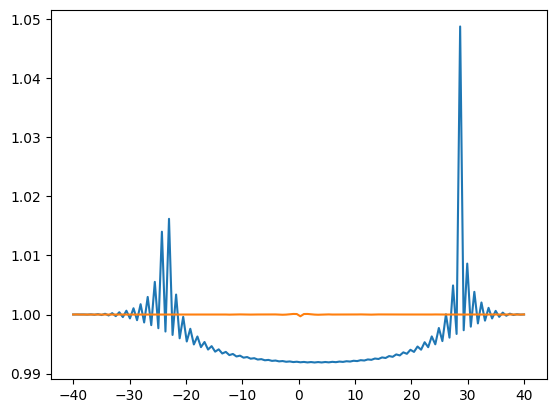

In [156]:
plt.plot(l,np.real((S[:,N//2])))
plt.plot(l,np.real((g[:,N//2])))

#plt.xlim(np.min(l),np.max(l))
#plt.xlim(0,.1)

In [13]:
l[0]-l[1]

-0.019540791402050672

In [59]:
np.max(S)

66.55514500346469

In [66]:
np.min(np.min(S))

0.0003699884752337802

In [159]:
np.transpose([np.arange(10)])

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [187]:
a=np.array(np.exp([-np.arange(10)]), dtype=complex)
b=np.transpose(a)

In [177]:
x = np.ones((10,10))

In [166]:
y1=x*a

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
       [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]])

In [167]:
x*b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5., 5., 5., 5., 5., 5.],
       [6., 6., 6., 6., 6., 6., 6., 6., 6., 6.],
       [7., 7., 7., 7., 7., 7., 7., 7., 7., 7.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]])

In [176]:
np.sum(x*b, axis = -1, keepdims=True)

array([[ 0.],
       [10.],
       [20.],
       [30.],
       [40.],
       [50.],
       [60.],
       [70.],
       [80.],
       [90.]])

In [345]:
N = 4
k = np.linspace(-1,1,N)
W_x = np.transpose(np.array([np.exp(-2j*np.pi*k/L)]))
iW_x = np.transpose(np.conj(np.array([np.exp(2j*np.pi*k/L)])))
W_y = np.array([np.exp(-2j*np.pi*k/L)])
iW_y = np.transpose(np.conj(W_y))
h = np.ones((N,N))
iW_x

array([[0.99691733+0.0784591j ],
       [0.99965732+0.02617695j],
       [0.99965732-0.02617695j],
       [0.99691733-0.0784591j ]])

In [346]:
coef_ffty_h = np.sum(h*W_y, axis = -1, keepdims=True)
coef_ffty_h

array([[3.99314932+1.38777878e-17j],
       [3.99314932+1.38777878e-17j],
       [3.99314932+1.38777878e-17j],
       [3.99314932+1.38777878e-17j]])

In [337]:
h2 = coef_ffty_h * iW_y
h2

array([[3.98083977-0.31329888j, 3.98083977-0.31329888j,
        3.98083977-0.31329888j, 3.98083977-0.31329888j],
       [3.99178096-0.10452846j, 3.99178096-0.10452846j,
        3.99178096-0.10452846j, 3.99178096-0.10452846j],
       [3.99178096+0.10452846j, 3.99178096+0.10452846j,
        3.99178096+0.10452846j, 3.99178096+0.10452846j],
       [3.98083977+0.31329888j, 3.98083977+0.31329888j,
        3.98083977+0.31329888j, 3.98083977+0.31329888j]])

In [342]:
coef_iffty_h = np.sum(h2*iW_y, axis = -1, keepdims=True)
coef_iffty_h

array([[15.77594809-2.49866471j, 15.77594809-2.49866471j,
        15.77594809-2.49866471j, 15.77594809-2.49866471j],
       [15.95070738-0.83594115j, 15.95070738-0.83594115j,
        15.95070738-0.83594115j, 15.95070738-0.83594115j],
       [15.95070738+0.83594115j, 15.95070738+0.83594115j,
        15.95070738+0.83594115j, 15.95070738+0.83594115j],
       [15.77594809+2.49866471j, 15.77594809+2.49866471j,
        15.77594809+2.49866471j, 15.77594809+2.49866471j]])

In [344]:
h3 = np.transpose(coef_iffty_h)*iW_y
h3

array([[15.53127314-3.72872878j, 15.83594949-2.0848423j ,
        15.96712386-0.41811385j, 15.92335908+1.25319554j],
       [15.70513465-2.91077466j, 15.92335908-1.25319554j,
        15.96712386+0.41811385j, 15.83594949+2.0848423j ],
       [15.83594949-2.0848423j , 15.96712386-0.41811385j,
        15.92335908+1.25319554j, 15.70513465+2.91077466j],
       [15.92335908-1.25319554j, 15.96712386+0.41811385j,
        15.83594949+2.0848423j , 15.53127314+3.72872878j]])

In [285]:
h*np.transpose(W_y)

array([[0.99691733+0.0784591j , 0.99691733+0.0784591j ,
        0.99691733+0.0784591j , 0.99691733+0.0784591j ],
       [0.99965732+0.02617695j, 0.99965732+0.02617695j,
        0.99965732+0.02617695j, 0.99965732+0.02617695j],
       [0.99965732-0.02617695j, 0.99965732-0.02617695j,
        0.99965732-0.02617695j, 0.99965732-0.02617695j],
       [0.99691733-0.0784591j , 0.99691733-0.0784591j ,
        0.99691733-0.0784591j , 0.99691733-0.0784591j ]])

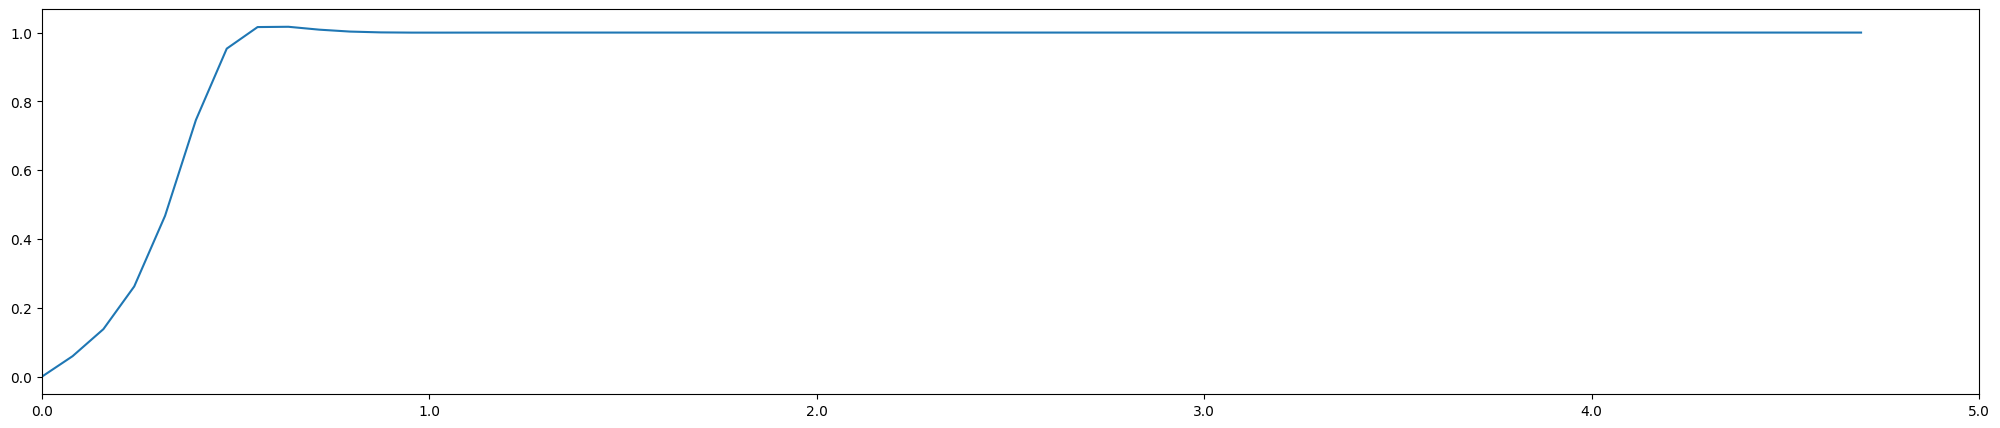

In [33]:
import numpy as np
import matplotlib.pyplot as plt

y = np.loadtxt("S.dat")
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(25,5))
axs.plot(y[0:60])
axs.set_xlim(0,20)
dk = 0.628319
L = 5
k0 = 2 * dk * 2 * L
b = np.linspace(0,5,6)
b2 = np.array([0,k0,2*k0,3*k0,4*k0,5*k0])
plt.setp(axs, xticks=b2, xticklabels=b)
plt.show()

In [29]:
3.11*4

12.44

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


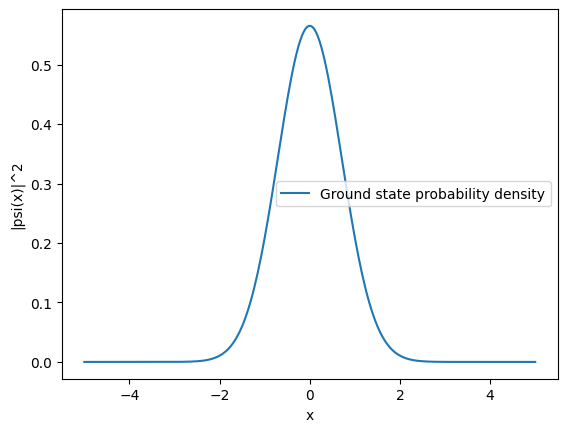

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft

# Define constants and parameters
hbar = 1.0
m = 1.0
L = 10.0
N = 256
dx = L / N
x = np.linspace(-L/2, L/2, N)
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Define the potential
V = 0.5 * x**2  # Harmonic oscillator potential

# Initial guess for the wave function
psi = np.exp(-x**2)

# Normalize the wave function
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)

# Time step
d_tau = 0.01
num_steps = 1000
counter = 1
for _ in range(num_steps):
    # Kinetic evolution (half step)
    psi_k = fft(psi)
    psi_k *= np.exp(-0.5 * (hbar**2 * k**2 / (2 * m)) * d_tau)
    psi = ifft(psi_k)
    
    # Potential evolution (full step)
    psi *= np.exp(-V * d_tau)
    
    # Kinetic evolution (half step)
    psi_k = fft(psi)
    psi_k *= np.exp(-0.5 * (hbar**2 * k**2 / (2 * m)) * d_tau)
    psi = ifft(psi_k)
    
    # Normalize the wave function at each step
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)
    print(counter)
    counter += 1
# Final normalized wave function
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(x, np.abs(psi)**2, label='Ground state probability density')
plt.xlabel('x')
plt.ylabel('|psi(x)|^2')
plt.legend()
plt.show()


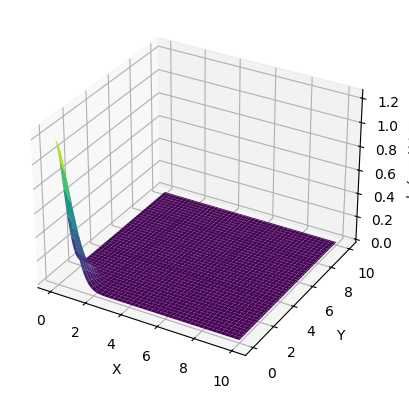

In [1]:
import numpy as np
from scipy.fftpack import dct, idct

# Define constants and parameters
hbar = 1.0
m = 1.0
L = 10.0
N = 128  # Using half grid points due to symmetry
dx = L / N
x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

# Define the potential in one quadrant
V = 0.5 * (X**2 + Y**2)  # Harmonic oscillator potential

# Initial guess for the wave function in one quadrant
psi = np.exp(-0.5 * (X**2 + Y**2))

# Normalize the wave function
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx * dx)

# Time step
d_tau = 0.01
num_steps = 1000

def dct2(x):
    return dct(dct(x.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return idct(idct(x.T, norm='ortho').T, norm='ortho')

# Precompute the DCT of the kinetic energy operator
kx = np.pi * np.arange(N) / L
ky = np.pi * np.arange(N) / L
KX, KY = np.meshgrid(kx, ky)
T = np.exp(-0.5 * (hbar**2 * (KX**2 + KY**2) / (2 * m)) * d_tau)

for _ in range(num_steps):
    # Kinetic evolution (half step)
    psi_k = dct2(psi)
    psi_k *= T
    psi = idct2(psi_k)
    
    # Potential evolution (full step)
    psi *= np.exp(-V * d_tau)
    
    # Kinetic evolution (half step)
    psi_k = dct2(psi)
    psi_k *= T
    psi = idct2(psi_k)
    
    # Normalize the wave function at each step
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx * dx)

# Final normalized wave function
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx * dx)

# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.abs(psi)**2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('|ψ(x, y)|^2')
plt.show()


Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110


KeyboardInterrupt: 

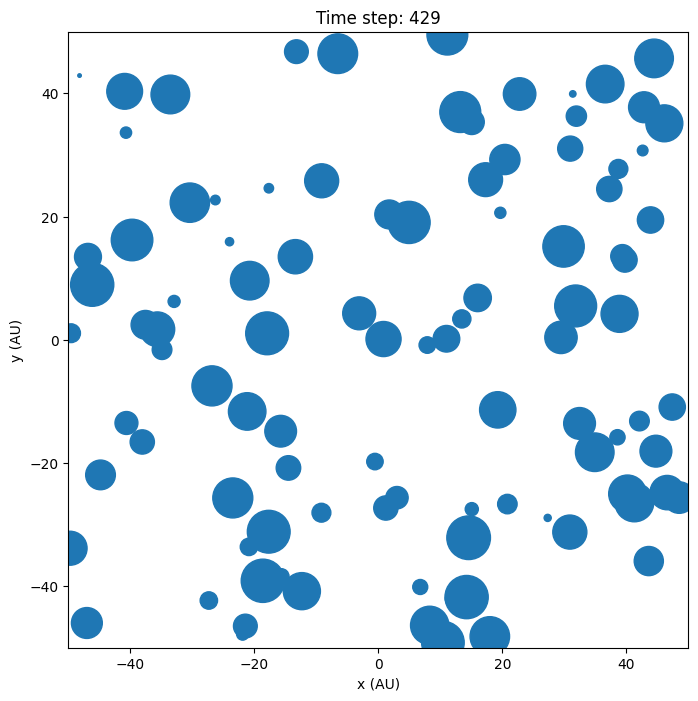

In [6]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

# Set the path to ffmpeg
matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# Constants
G = 6.67430e-11  # Gravitational constant
M_sun = 1.989e30  # Mass of the Sun
AU = 1.496e11  # Astronomical Unit (m)

# Simulation parameters
n_bodies = 100  # Number of initial bodies
mass_min = 1e22  # Minimum mass of a body (kg)
mass_max = 1e25  # Maximum mass of a body (kg)
radius = 50 * AU  # Radius of the disk (m)
time_step = 1e4  # Time step (s) - reduced for better dynamics
n_steps = 1000  # Number of simulation steps
merge_distance = 5e9  # Distance at which bodies merge (m) - reduced for more dynamics

# Initialize bodies with random positions and velocities
np.random.seed(42)  # For reproducibility
masses = cp.array(np.random.uniform(mass_min, mass_max, n_bodies))
positions = cp.array(np.random.uniform(-radius, radius, (n_bodies, 2)))
initial_velocity_scale = 1e4  # Increased initial velocity scale for more dynamics
velocities = cp.array(np.random.normal(0, initial_velocity_scale, (n_bodies, 2)))

# Function to compute gravitational forces
def compute_forces(positions, masses):
    forces = cp.zeros_like(positions)
    for i in range(n_bodies):
        for j in range(i + 1, n_bodies):
            r_ij = positions[j] - positions[i]
            dist = cp.linalg.norm(r_ij)
            if dist > 0:
                force_magnitude = G * masses[i] * masses[j] / dist**2
                force_direction = r_ij / dist
                forces[i] += force_magnitude * force_direction
                forces[j] -= force_magnitude * force_direction
    return forces

# Function to update positions and velocities
def update(positions, velocities, masses, forces, time_step):
    velocities += forces / masses[:, None] * time_step
    positions += velocities * time_step
    return positions, velocities

# Function to handle merging of bodies
def merge_bodies(positions, velocities, masses, merge_distance):
    new_positions = []
    new_velocities = []
    new_masses = []
    merged = cp.zeros(n_bodies, dtype=bool)
    for i in range(n_bodies):
        if not merged[i]:
            merge_list = [i]
            for j in range(i + 1, n_bodies):
                if not merged[j] and cp.linalg.norm(positions[j] - positions[i]) < merge_distance:
                    merge_list.append(j)
                    merged[j] = True
            total_mass = cp.sum(masses[merge_list])
            weighted_pos = cp.sum(positions[merge_list] * masses[merge_list, None], axis=0) / total_mass
            weighted_vel = cp.sum(velocities[merge_list] * masses[merge_list, None], axis=0) / total_mass
            new_positions.append(weighted_pos)
            new_velocities.append(weighted_vel)
            new_masses.append(total_mass)
    return cp.array(new_positions), cp.array(new_velocities), cp.array(new_masses)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

def init():
    ax.set_xlim(-radius / AU, radius / AU)
    ax.set_ylim(-radius / AU, radius / AU)
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    return []

# Animation update function
def animate(step):
    global positions, velocities, masses, n_bodies
    print(f"Step: {step}")  # Print the current step to the terminal
    forces = compute_forces(positions, masses)
    positions, velocities = update(positions, velocities, masses, forces, time_step)
    positions, velocities, masses = merge_bodies(positions, velocities, masses, merge_distance)
    n_bodies = len(masses)
    
    ax.clear()
    ax.set_xlim(-radius / AU, radius / AU)
    ax.set_ylim(-radius / AU, radius / AU)
    ax.set_xlabel('x (AU)')
    ax.set_ylabel('y (AU)')
    ax.set_title(f'Time step: {step}')
    scatter = ax.scatter(cp.asnumpy(positions[:, 0]) / AU, cp.asnumpy(positions[:, 1]) / AU, s=cp.asnumpy(masses) / mass_min)
    
    return scatter,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=n_steps, init_func=init, blit=True)

# Save the animation as a video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('protoplanetary_formation.mp4', writer=writer)

plt.show()


In [5]:
ani.save('protoplanetary_formation.mp4', writer='ffmpeg', fps=30)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110
